# Create datasets from database extractions

### Imports

In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager
import seaborn as sn
from scipy.stats import zscore
import numpy as np
import statsmodels.api as sm

from itertools import product


#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
sn.set_style("white")

from scipy.spatial import cKDTree

csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':12}

### Read and prepare data

In [2]:
#dd = pd.read_csv(r"../data/pois_other_300.csv")
df = pd.read_csv(r"../data/level1_edm2018.csv",sep=",")


### Proximity trips

In [3]:
# Filter MRM. Get only targeted trips
df = df[df['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
df['CODMUNI'] = df['CODMUNI'].astype(str).str.zfill(3)
df['edge_id'] = df['VORIZT1259']+"|"+df['VDESZT1259']
relations = df['edge_id'].unique()
df.drop_duplicates(subset=['ID_HOGAR','ID_IND','ID_VIAJE'],inplace=True)
df = df[df['VDES']!='Casa']
df = df[df['VORI']=='Casa']
df = df[df['C8ACTIV']!='Otra situación']
df = df[df['CPMR'] == 'No']
df = df[~df['VFRECUENCIA'].isin(['Alguna vez','Es la primera vez que hago el viaje'])]
df = df[df['MOTIVO_PRIORITARIO'].isin(['Compras','Estudio', 'Ocio', 'Deporte/ dar un paseo','Acompañamiento a otra persona','Médico'])]
df = df[df['DISTANCIA_VIAJE'] < 900] #Weird outliers, distance is in KM

### Time and Speed columns

In [4]:
#Make time columns and speed column
df['VORIHORAINI'] = df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[2:]
df['VDESHORAFIN'] = df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[2:]
df = df[~df['VDESHORAFIN'].str.startswith(("25","26"))]
df = df[~df['VORIHORAINI'].str.startswith(("25","26"))]
df.loc[df['VORIHORAINI'].str.startswith("24"),'VORIHORAINI'] = df[df['VORIHORAINI'].str.startswith("24")]['VORIHORAINI'].str.replace("24:","00:")
df.loc[df['VDESHORAFIN'].str.startswith("24"),'VDESHORAFIN'] = df[df['VDESHORAFIN'].str.startswith("24")]['VDESHORAFIN'].str.replace("24:","00:")
df['VDESHORAFIN'] = pd.to_datetime(df['VDESHORAFIN'], format= '%H:%M' )
df['VORIHORAINI'] = pd.to_datetime(df['VORIHORAINI'], format= '%H:%M' )
df['DURACION_VIAJE'] = ((df['VDESHORAFIN'] - df['VORIHORAINI']).dt.seconds)/60
df['VELOCIDAD_VIAJE'] = df['DISTANCIA_VIAJE']/(df['DURACION_VIAJE']/60)
df['DURACION_VIAJE'].fillna(0,inplace=True)
df['VELOCIDAD_VIAJE'].fillna(0,inplace=True)
df['VDESHORAFIN'] = df['VDESHORAFIN'].dt.hour
df['VORIHORAINI'] = df['VORIHORAINI'].dt.hour

#Dropping some more outliers
df = df[df['VELOCIDAD_VIAJE'] < 80]
df = df[df['DURACION_VIAJE'] < 300]
df = df[df['DURACION_VIAJE'] >= 0]
df = df[df['N_VIAJES_POR_HOGAR'] < 20]
df = df[df['DISTANCIA_VIAJE'] < 20]


C:\Users\katul\AppData\Local\Temp\ipykernel_11672\3719476270.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DURACION_VIAJE'].fillna(0,inplace=True)
C:\Users\katul\AppData\Local\Temp\ipykernel_11672\3719476270.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### Mapping values

In [5]:
categorical = {
    'C2SEXO':('Gender',{'Hombre':'Male','Mujer':'Female'},(0,0)),
    'C4NAC':('Foreign',{'No':'No','Si':'Yes'},(0,1)),
    'CPMR':('PRM',{'No':'No','Si':'Yes'},(1,0)),
    'C13TARJETA':('TravelCard',{'Tarjeta de Transporte Público TTP':"Yes", 'Ninguna':"No", 'Ambas tarjetas':"Yes",'Tarjeta MULTI':"Yes"},(1,1)),
    'VVEHICULO':('HasVehicle',{'Si':'Yes','No':'No'},(2,0)),
    'C6CARNE':('HasLicense',{'No tiene':"No", 'Carné de coche (B) o superior  (C, D ó E)':"Yes",'Carné de moto y coche':"Yes", 'Carné de moto A1/A2':"Yes", 'Sólo licencia de ciclomotor':"Yes"},(2,1)),
    'VFRECUENCIA':('Frequency',{'A diario, de lunes a viernes':"Daily",'Entre 2 y 4 días laborables por semana':"Frequently",'Es la primera vez que hago el viaje':"0",'Menos de dos días laborables por semana':"Less Frequently", 'Alguna vez':"Sometimes"},(3,0)),
    'DIASEM':('DayOfWeek',{"Lunes":"Monday","Martes":"Tuesday","Miércoles":"Wednesday","Jueves":"Thursday"},(3,1)),
    'C7ESTUD':('EducationLevel',{'Primera etapa de Educación Secundaria y similar':"Second - A",'Educación Primaria':"First",'Segunda etapa de Educación Secundaria y similar':"Second - B",'Menos que Primaria':"No",'Enseñanzas de Formación Profesional de grado superior y equivalentes':"Third",'Educación postsecundaria no superior':"Second - B", 'Grados universitarios/licenciaturas/másteres y enseñanzas de doctorado':"Third"},(4,0)),
    'C8ACTIV':('Activity',{'Parado, ha trabajado antes':"Unemployed", 'Jubilado / Retirado/ Pensionista':"Retired",'Estudiante':"Student", 'Trabaja':"Worker", 'Trabaja y estudia':"Worker",'Cuidado de familiares':"Caretaker", 'Trabajo doméstico no remunerado':"Caretaker", 'Parado, busca primer trabajo':"Unemployed"},(4,1)),
    'VNOPRIVADO':("NoPrivate",{'No me gusta el coche':"Dislike", 'Más incómodo':"Less Convenient",'Evitar el atasco':"Congestion",'Contamino menos':"Other",'Dificultad de aparcamiento':"Hard to Park",'Otros':"Other",'Tardo más':"Takes Longer",'Es más caro':"Other"},(5,0)),
    'VNOPUBLICO':("NoPublic",{'No hay servicio público':"Bad Service",'Es más caro':"Other",'Tardo más':"Takes Longer",'El destino está muy cerca':"Very Close",'Otros':"Other",'Necesito mi vehículo para trabajar o gestión personal':"Other",'Mala combinación del tte.público':"Bad Service",'Prefiero ir andando / en bicicleta':"Prefer Active Modes",'Mi situación personal condiciona esta elección modal':"Bad Service",'Más incómodo':"Less Convenient", 'Por desconocimiento/falta de información':"Other",'No me gusta el tte. público':"Other"},(5,1)),
    "MOTIVO_PRIORITARIO":("TripPurpose",{'Compras':"Shopping",'Ocio':"Leisure",'Estudio':"Study",'Trabajo':"Work",'Deporte/ dar un paseo':"Sport / Stroll",'Otro domicilio':"Other",'Asunto personal':"Other",'Acompañamiento a otra persona':"Care",'Médico':"Care",'Gestión de trabajo':"Work",'Otros':"Other"},(6,0)),
    "MODO_PRIORITARIO":("TransportMode",{'Coche conductor particular' :"Motor - Personal",'Coche pasajero particular':"Motor - Personal",'Moto/ciclomotor particular':"Motor - Personal",'Andando/pie' : "Walking",'Autobus urbano Madrid EMT':"Bus",'Autobus interurbano':"Bus",'Autobus discrecional':"Bus",'Autobus de largo recorrido':"Bus",'Autobus urbano otro municipio':"Bus",'Otros':"Other",'Metro':"Train",'Renfe Cercanías':"Train",'Resto renfe':"Train",'Metro ligero/tranvía':"Train", 'Coche conductor empresa' : "Motor - Shared",'Coche pasajero empresa': "Motor - Shared",'Taxi':"Motor - Shared",'Coche pasajero alquiler con conductor': "Motor - Shared",'Coche conductor alquiler sin conductor': "Motor - Shared",'Moto/ciclomotor empresa': "Motor - Shared",'Moto/ciclomotor publica': "Motor - Shared",'Bicicleta particular':"Cycling",'Bicicleta publica':"Cycling",'Bicicleta empresa':"Cycling"},(6,1))
    }

for c,i in categorical.items():

    df[c] = df[c].map(i[1])
    df.rename(columns={c:i[0]},inplace=True)

df.rename(columns = {'DISTANCIA_VIAJE':'TripDistance'},inplace=True)

continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'N_ETAPAS_POR_VIAJE':('TripStages',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1)),
    'DURACION_VIAJE':('TripDuration',(3,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(3,1))
    }

for c,i in continuous.items():

    df.rename(columns={c:i[0]},inplace=True)
    df[i[0]] = df[i[0]].astype(float)


### Building age buckets

In [6]:
df.loc[df['Age']<5,'Age Status'] = "Less than 5"
df.loc[(df['Age']>=5) & (df['Age']<12),'Age Status'] = "Ages 6-12"
df.loc[(df['Age']>=12) & (df['Age']<18),'Age Status'] = "Ages 13-18"
df.loc[(df['Age']>=18) & (df['Age']<40),'Age Status'] = "Ages 19-40"
df.loc[(df['Age']>=40) & (df['Age']<65),'Age Status'] = "Ages 41-65"
df.loc[df['Age']>=65,'Age Status'] = "More than 65"

### Make Local Household columns and 15M trips column

In [7]:

hd = {}
h15 = {}
h30 = {}
for h in list(df['ID_HOGAR'].unique()):
    dist = list(df[df['ID_HOGAR'] == h]['TripDuration'].values)
    
    if all(di < 30 for di in dist): h30.update({h:1})
    else: h30.update({h:0})
    
    if all(di < 15 for di in dist): h15.update({h:1})
    else: h15.update({h:0})

    hd.update({h:'Other'})
    d = df[df['ID_HOGAR'] == h][['ID_IND','Age','Age Status','HouseholdSize','Activity']].drop_duplicates(subset='ID_IND')
    if d['HouseholdSize'].values[0] == 1:
        if d['Activity'].values[0] == 'Retired': hd.update({h:'Retirees'})
        elif d['Activity'].values[0] == 'Student': hd.update({h:'Students (age 19+)'})
        elif d['Activity'].values[0] in ['Worker']: hd.update({h:'Full-Time Workers'})
        else: hd.update({h:'Other'})
    else:
        if any(act in ['Retired'] for act in d['Activity'].values): hd.update({h:'Retirees'})
        if any(act in ['Worker'] for act in d['Activity'].values): hd.update({h:'Full-Time Workers'})
        if any(age == "Ages 13-18" for age in d['Age Status'].values): hd.update({h:'Students (Age 13–18)'})
        if any(age == "Ages 6-12" for age in d['Age Status'].values): hd.update({h:'Students (Age 6–12)'})
        if any(age == "Less than 5" for age in d['Age Status'].values): hd.update({h:'Children'})
        
df['HouseholdStructure'] = df['ID_HOGAR'].map(hd)

df['Trip15'] = ""
df.loc[df['TripDuration']<=15,'Trip15'] = 'Yes'
df.loc[df['TripDuration']>15,'Trip15'] = 'No'



### Final column schema

In [8]:
df.drop(columns=['ID_ETAPA','Foreign', 'C5CAM','C9PROF', 'C10SECTOR','C14ABONO', 'DDIA','DMES', 'DANNO', 'DayOfWeek', 'DNOVIAJO','C11ZT1259', 'C12ZT1259','PRM', 'TIPO_ENCUESTA','NOMMUNI', 'CODPROV', 'NOMPROV',
       'ZT1259', 'CZ208', 'ELE_HOGAR_NUEVO', 'A1PER', 'A2PER4', 'B1NVE',
       'V1B11TIPO', 'V1B12CARB', 'V1B13EST', 'V2B11TIPO1', 'V2B12CARB1',
       'V2B13EST1', 'V3B11TIPO1', 'V3B12CARB1', 'V3B13EST1', 'V4B11TIPO1',
       'V4B12CARB1', 'V4B13EST1', 'V5B11TIPO1', 'V5B12CARB1', 'V5B13EST1','EMODO', 'EMODO1','MODO', 'ELINEAEMPRESA_ORIGINAL', 'ESUBIDA', 'ESUBIDA_cod', 'EBAJADA',
       'EBAJADA_cod', 'ETITULO', 'EESTACIONA', 'EOCUPACION', 'ETDESPH',
       'COD_MUN_PARADA', 'ELE_G_POND_Esc2', 'VORI','VDES',
       'EndTime', 'Frequency',  'VDESZT1259', 'ELE_G_POND_ESC2', 'edge_id', 'TripSpeed','Trip15'],inplace=True)

map = {'CODMUNI':'id_municipality', 'VORIZT1259':'id_taz','ELE_G_POND':'elevator',  'ID_HOGAR':'id_household','ID_IND':'id_person', 'ID_VIAJE':'id_trip',
   'TripPurpose':'trip_purpose', 'TripDistance':'trip_distance','TripStages':'trip_stages', 'TripDuration':'trip_duration', 'TransportMode':'trip_mode',
   'Gender':'dem_gender', 'Age':'dem_age','Age Status':'dem_cohort','EducationLevel':'dem_education', 'Activity':'dem_activity',
   'HouseholdSize':'dem_hou_size','HouseholdStructure':'dem_hou_structure','TripsHousehold':'dem_hou_trips',
   'HasLicense':'dem_att_license', 'HasVehicle':'dem_att_vehicle',
   'TravelCard':'dem_att_card', 'NoPrivate':'dem_att_noprivate', 'NoPublic':'dem_att_nopublic'}

df = df[map.keys()].rename(columns=map)

df['id'] = df['id_household'].astype(int).astype(str)+df['id_person'].astype(int).astype(str)+df['id_trip'].astype(int).astype(str)

In [9]:
print(df.head(5).to_string())

    id_municipality    id_taz    elevator  id_household  id_person  id_trip trip_purpose  trip_distance  trip_stages  trip_duration         trip_mode dem_gender  dem_age    dem_cohort dem_education dem_activity  dem_hou_size     dem_hou_structure  dem_hou_trips dem_att_license dem_att_vehicle dem_att_card dem_att_noprivate     dem_att_nopublic      id
188             005  005-024A  123.082283          4937          1      1.0     Shopping       0.557033          1.0           30.0           Walking     Female     77.0  More than 65    Second - B      Retired           5.0  Students (Age 13–18)           10.0              No              No           No             Other  Prefer Active Modes  493711
194             005  005-024A  175.169238          4937          4      1.0        Study       1.069979          1.0           10.0  Motor - Personal     Female     18.0    Ages 19-40    Second - B      Student           5.0  Students (Age 13–18)           10.0              No              N

### Getting extraction datasets

In [10]:
datasets = [
r"../data/pois_network_centrality_300.csv",
r"../data/pois_network_centrality_600.csv",
r"../data/pois_network_centrality_900.csv",
r"../data/pois_network_centrality_1200.csv",
r"../data/pois_network_centrality_1500.csv",
r"../data/pois_design_300.csv",
r"../data/pois_design_600.csv",
r"../data/pois_design_900.csv",
r"../data/pois_design_1200.csv",
r"../data/pois_design_1500.csv",
r"../data/pois_other_300.csv",
r"../data/pois_other_600.csv",
r"../data/pois_other_900.csv",
r"../data/pois_other_1200.csv",
r"../data/pois_other_1500.csv",
r"../data/pois_walkable_trips_300.csv",
r"../data/pois_walkable_trips_600.csv",
r"../data/pois_walkable_trips_900.csv",
r"../data/pois_walkable_trips_1200.csv",
r"../data/pois_walkable_trips_1500.csv",
r"../data/pois_transacc_300.csv",
r"../data/pois_transacc_600.csv",
r"../data/pois_transacc_900.csv",
r"../data/pois_transacc_1200.csv",
r"../data/pois_transacc_1500.csv",
r"../data/pois_parkacc_300.csv",
r"../data/pois_parkacc_600.csv",
r"../data/pois_parkacc_900.csv",
r"../data/pois_parkacc_1200.csv",
r"../data/pois_parkacc_1500.csv",
r"../data/pois_far_localacc_300.csv",
r"../data/pois_far_localacc_600.csv",
r"../data/pois_far_localacc_900.csv",
r"../data/pois_far_localacc_1200.csv",
r"../data/pois_far_localacc_1500.csv"]
#Name dataframes
data = {d.split("/")[-1].split(".")[0]:pd.read_csv(d) for d in datasets}
#Schema
for k,v in data.items():
    data[k] = v[['poi_id']+[c for c in v.columns if not c in ['poi_id','tz_id','local_population','geometry']]]
#Had to rename park sizes
for k,v in data.items():
    if 'pois_parkacc' in k:
        data[k] = pd.concat([v[v['park_type'] == t].set_index('poi_id')['unique_parks_count'].rename(f'acc_parks_{t}') for t in ["S","M","L"]],axis=1)
    else: data[k] = v.set_index('poi_id')

### Get a template of pois

In [11]:
template = pd.read_csv(r"../data/fn_pois_template.csv").set_index('poi_id')
template['geometry'] = template['geometry'].apply(loads)
template = gpd.GeoDataFrame(template, geometry='geometry', crs= 25830)
print(template.head().to_string())

                    tz_id  node_id  local_population  housing                        geometry
poi_id                                                                                       
28900-1-50325  079-01-014    76900               0.0      0.0  POINT (440494.664 4474199.228)
28900-1-50397  079-01-020    74795               2.0      1.0  POINT (440494.189 4473713.975)
28900-1-50561  079-01-020    74683              32.0     16.0       POINT (440503.63 4473790)
28900-1-51544  079-06-108   110560              10.0      4.0  POINT (440602.755 4479324.714)
28900-1-51874  079-06-112   106716               9.0      4.0  POINT (440617.971 4478888.682)


### Get betweenness dataset (was calculated with QGIS)

In [12]:
btw = gpd.read_file(r"G:\Mi unidad\walknet_datalake\temp\betweenness.gpkg")[['degree','closeness','betweenness','eigenvector','geometry']].rename(columns ={'degree':'des_degree','closeness':'des_closeness','betweenness':'des_betweenness','eigenvector':'des_eigenvector'})

### Merge datasets and arrange schema

In [13]:
cols = ['tz_id', 'node_id', 'local_population', 

'dem_income', 'dem_household_size', 'dem_mean_age',
'dem_population_18', 'dem_population_65',

'acc_care_other','acc_care_public',
'acc_school_superior', 'acc_school_basic',
'acc_leisure_bar', 'acc_leisure_cultural', 'acc_leisure_shows',
'acc_shopping_mall', 'acc_shopping_market', 'acc_shopping_alone',
'acc_sport_other',
'acc_transportation',
'acc_parks_S', 'acc_parks_M', 'acc_parks_L',
'dens_pop_total', 'dens_hou_total',
'dens_far', 'dens_far_ag',
'den_perc_unbuilt', 'dens_built_total',
'den_perc_housing_sfr','den_perc_housing_ch',
'den_perc_care_other', 'den_perc_care_public',
'den_perc_school_superior', 'den_perc_school_basic',
'den_perc_leisure_bar', 'den_perc_leisure_cultural',
'den_perc_leisure_shows', 'den_perc_shopping_mall',
'den_perc_shopping_market', 'den_perc_shopping_alone',
'den_perc_sport_other', 'den_perc_office', 'den_perc_industrial',
'den_perc_storage', 'den_perc_parking', 'den_perc_hotel',
'den_perc_religious', 'den_perc_infra', 

'div_wt_care', 'div_ut_care', 'div_wt_school', 'div_ut_school',
'div_wt_leisure', 'div_ut_leisure', 'div_wt_shopping',
'div_ut_shopping', 'div_wt_sport', 'div_ut_sport', 

'des_mean_degree', 'des_straightness', #'des_betweenness',
'des_total_length','des_block_length', 'des_culdesac', 'des_slope','des_building_age',
       
'geometry']

df_300 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "300" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_600 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "600" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_900 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "900" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1200 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1200" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1500 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1500" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]

### Further filter extraneous data or unpopulated pois (not needed at this point anymore)

In [14]:
df_300 = df_300[df_300['local_population'] > 0]
df_600 = df_600[df_600['local_population'] > 0]
df_900 = df_900[df_900['local_population'] > 0]
df_1200 = df_1200[df_1200['local_population'] > 0]
df_1500 = df_1500[df_1500['local_population'] > 0]
df_300 = df_300[df_300['des_building_age'] > 1880]
df_600 = df_600[df_600['des_building_age'] > 1880]
df_900 = df_900[df_900['des_building_age'] > 1880]
df_1200 = df_1200[df_1200['des_building_age'] > 1880]
df_1500 = df_1500[df_1500['des_building_age'] > 1880]

### Had to make this nearest join function to merge the betweeness data

In [15]:
def join_by_nearest(gdf1,gdf2):

    gdf1_coords = gdf1.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    gdf2_coords = gdf2.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

    tree_gdf1 = cKDTree(gdf1_coords)
    tree_gdf2 = cKDTree(gdf2_coords)

    distances, indices = tree_gdf1.query(gdf2_coords, k=1)

    valid_indices = [i for i in range(len(indices)) if indices[i] < len(gdf1)]

    results = pd.DataFrame({
        'gdf1_index': [indices[i] for i in valid_indices],
        'gdf2_index': valid_indices,
        'distance': [distances[i] for i in valid_indices]
    })

    gdf1_matched = gdf1.iloc[results['gdf1_index']].reset_index(drop=True)
    gdf2_matched = gdf2.iloc[results['gdf2_index']].reset_index(drop=True)

    return gdf1_matched.join(gdf2_matched, lsuffix='', rsuffix='_gdf2')

df_300 = join_by_nearest(df_300,btw)#.drop('geometry_gdf2')
df_600 = join_by_nearest(df_600,btw)
df_900 = join_by_nearest(df_900,btw)
df_1200 = join_by_nearest(df_1200,btw)
df_1500 = join_by_nearest(df_1500,btw)


### Set CRS

In [16]:
df_300 = df_300.set_crs(25830)
df_600 = df_600.set_crs(25830)
df_900 = df_900.set_crs(25830)
df_1200 = df_1200.set_crs(25830)
df_1500 = df_1500.set_crs(25830)

In [17]:
### Aggregate data into TAZs

In [18]:
def agg_tzs(df):
    df = df[df['local_population'] != 0]
    # Exclude unwanted columns from the weighted average calculation
    columns_to_average = [
        col for col in df.columns if col not in [
            'geometry', 'node_id', 'tz_id', 'local_population', 
            'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 
            'right', 'bottom', 'row_index', 'col_index'
        ]
    ]
    
    # Function to calculate the weighted average for each column
    def weighted_average(dfg):
        weights = dfg['local_population']
        result = {}
        for col in columns_to_average:
            # Filter out rows with NaN values in the current column
            valid_rows = dfg[~dfg[col].isna()]
            if valid_rows.empty:
                result[col] = None  # Assign None if no valid rows are left
            else:
                weights_filtered = valid_rows['local_population']
                result[col] = (valid_rows[col] * weights_filtered).sum() / weights_filtered.sum()
        return pd.Series(result)
    
    # Group by tz_id and calculate the weighted average for each column
    df_aggregated = df.groupby('tz_id')[['local_population'] + columns_to_average].apply(weighted_average).reset_index()
    
    return df_aggregated

df_tz_300 = agg_tzs(df_300)
df_tz_600 = agg_tzs(df_600)
df_tz_900 = agg_tzs(df_900)
df_tz_1200 = agg_tzs(df_1200)
df_tz_1500 = agg_tzs(df_1500)

### Categorical age buckets

In [19]:
df_tz_1500['des_building_age'] = df_tz_1500['des_building_age'].fillna(0).astype(int)
df_tz_1200['des_building_age'] = df_tz_1200['des_building_age'].fillna(0).astype(int)
df_tz_900['des_building_age'] = df_tz_900['des_building_age'].fillna(0).astype(int)
df_tz_600['des_building_age'] = df_tz_600['des_building_age'].fillna(0).astype(int)
df_tz_300['des_building_age'] = df_tz_300['des_building_age'].fillna(0).astype(int)


bins = [1880, 1930, 1960, 1980, 2000, 2010, 2018]
labels = ['1880-1930', '1930-1960', '1960-1980', '1980-2000', '2000-2010', '2010-2018']

df_tz_300['des_age_range'] = pd.cut(df_tz_300['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_600['des_age_range'] = pd.cut(df_tz_600['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_900['des_age_range'] = pd.cut(df_tz_900['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_1200['des_age_range'] = pd.cut(df_tz_1200['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_1500['des_age_range'] = pd.cut(df_tz_1500['des_building_age'], bins=bins, labels=labels, right=False)

### Categorical density buckets

In [20]:
labels = ['den_hou_Q1','den_hou_Q2','den_hou_Q3','den_hou_Q4']
df_tz_300['den_quartile'] = pd.qcut(df_tz_300['dens_hou_total'], 4, labels=labels)
df_tz_600['den_quartile'] = pd.qcut(df_tz_600['dens_hou_total'], 4, labels=labels)
df_tz_900['den_quartile'] = pd.qcut(df_tz_900['dens_hou_total'], 4, labels=labels)
df_tz_1200['den_quartile'] = pd.qcut(df_tz_1200['dens_hou_total'], 4, labels=labels)
df_tz_1500['den_quartile'] = pd.qcut(df_tz_1500['dens_hou_total'], 4, labels=labels)

### Merge and export

In [21]:
ds_1500 = pd.merge(df, df_tz_1500, left_on='id_taz',right_on="tz_id",how='left')
ds_1200 = pd.merge(df, df_tz_1200, left_on='id_taz',right_on="tz_id",how='left')
ds_900 = pd.merge(df, df_tz_900, left_on='id_taz',right_on="tz_id",how='left')
ds_600 = pd.merge(df, df_tz_600, left_on='id_taz',right_on="tz_id",how='left')
ds_300 = pd.merge(df, df_tz_300, left_on='id_taz',right_on="tz_id",how='left')

for dft in ('300',ds_300),('600',ds_600),('900',ds_900),('1200',ds_1200),('1500',ds_1500):
    dft[1].to_parquet(r"../data/extraction_{di}.parquet".format(di = dft[0]))

### Dataset Balance Inspection and Figures

In [32]:
lists = {
        'trip_purpose' : ds_900.trip_purpose.unique(),
        'dem_cohort' : ds_900.dem_cohort.unique()}
        #'des_age_range': ds_900.des_age_range,
        #'den_quartile': ds_900.den_quartile}

lists_with_all = {key: list(values) + ["all"] for key, values in lists.items()}

# Generate all combinations of the lists
combinations = product(*lists_with_all.values())

# Build dictionaries for each combination
dict_combinations = [dict(zip(lists_with_all.keys(), combination)) for combination in combinations]


In [33]:
control_combinations  = {"|".join([str(e) for e in di.values()]):di for di in dict_combinations}

In [34]:
# Function to filter DataFrame based on a dictionary
def filter_dataframe(df, filter_dict):
    filtered_df = df.copy()
    for key, value in filter_dict.items():
        if value != "all":
            filtered_df = filtered_df[filtered_df[key] == value]
    return filtered_df

In [35]:
# Create one DataFrame per combination
target_dataframes = {'300':{},'600':{},'1200':{},'900':{},'1500':{}}
for dft in ('300',ds_300),('600',ds_600),('900',ds_900),('1200',ds_1200),('1500',ds_1500):
    for name, combo in control_combinations.items():
        filtered_df = filter_dataframe(dft[1], combo)
        target_dataframes[dft[0]].update({name: filtered_df})

In [36]:
i = 0
for dist, dat in target_dataframes.items():
    for name, filtered_df in dat.items():
        if not filtered_df.empty:
            i+= 1
            print(f"Distance threshold {dist}")
            print(f"Combination: {name}")
            print(str(len(filtered_df)))
            print(str(filtered_df['elevator'].sum()))
            print("-" * 40)
        

Distance threshold 300
Combination: Shopping|More than 65
2364
167419.74832958376
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 19-40
656
50467.19353975711
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 13-18
39
3605.2086387433365
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 6-12
35
2475.6725249723136
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 41-65
3261
222958.79295244825
----------------------------------------
Distance threshold 300
Combination: Shopping|Less than 5
11
836.8621267788669
----------------------------------------
Distance threshold 300
Combination: Shopping|all
6366
447763.4781122836
----------------------------------------
Distance threshold 300
Combination: Study|More than 65
75
5682.949816344311
----------------------------------------
Distance threshold 300
Combination: Study|Ages 19-4

In [37]:
sample_metrics = {}
for dist, dfs in target_dataframes.items():
    for name, df in dfs.items():
        if df['elevator'].sum() > 45000:
            table_size = len(df)
            sample_size = df['elevator'].sum()
            sample_walk = df[df['trip_mode']=='Walking']['elevator'].sum()
            sample_drive = df[df['trip_mode']=='Motor - Personal']['elevator'].sum()
            walk_perc = round((100 * sample_walk) / sample_size,0)
            drive_perc = round((100 * sample_drive) / sample_size,2)
            sample_metrics.update({f"{dist}|{name}":{'table_size': table_size,'sample_size': sample_size,'sample_walk': sample_walk,'sample_drive': sample_drive, 'walk_perc':walk_perc, 'drive_perc':drive_perc}})


In [38]:
sample_metrics = pd.DataFrame.from_dict(sample_metrics, orient='index').fillna(0)
sample_metrics['sample_size'] = sample_metrics.sample_size.astype(int)

In [39]:
sample_metrics.reset_index(inplace=True)
sample_metrics = sample_metrics[sample_metrics['index'].str.contains('1500')]

In [40]:
# Sort the data by sample_size in descending order

df_sorted = sample_metrics.copy()
df_sorted.set_index('index',inplace=True)

df_sorted['walk_size'] = df_sorted['sample_walk'] 
df_sorted['drive_size'] = df_sorted['sample_drive']

# Ensure proper sorting and data handling
df_sorted = df_sorted.sort_values(by='sample_size', ascending=True)



C:\Users\katul\AppData\Local\Temp\ipykernel_11672\2488188413.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


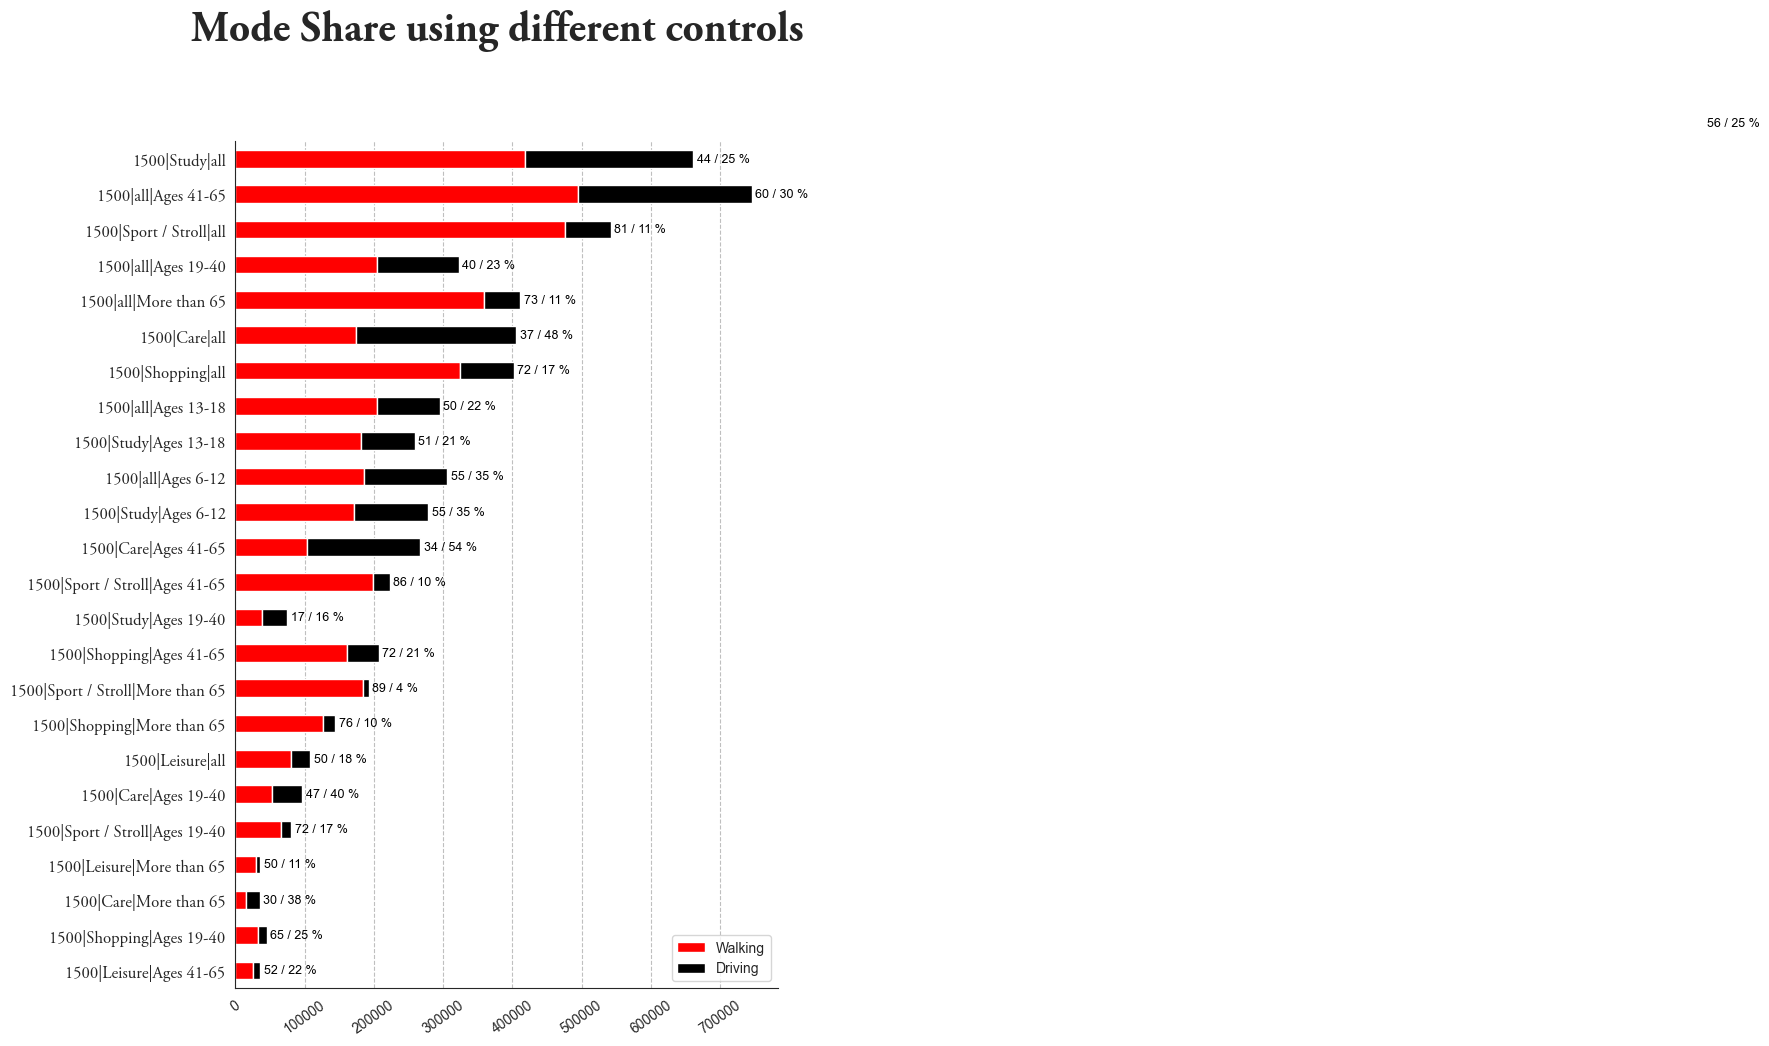

In [43]:
fig, ax = plt.subplots(figsize=(7, 11))
fig.suptitle('Mode Share using different controls', fontweight="bold", y=1, **csfont)

cr = {
    'walk_size': 'red',
    'drive_size': 'black'}

df_sorted[df_sorted.index != '1500|all|all'][['walk_size','drive_size']].rename(columns={'walk_size':"Walking",'drive_size':"Driving"}).plot(kind='barh',stacked=True,ax=ax, color=['red','black']) 


for i, (index, row) in enumerate(df_sorted[df_sorted.index != '900|all|all'].iterrows()):
    # Calculate the total length of the stacked bar
    total_length = row['walk_size'] + row['drive_size']
    
    # Create the label text in the format "{walk_perc} / {drive_perc}"
    label_text = f"{row['walk_perc']:.0f} / {row['drive_perc']:.0f} %"
    
    # Place the label at the end of the bar
    ax.text(
        x=total_length + 5000,  # Slightly offset to the right of the bar
        y=i,  # Corresponds to the bar index
        s=label_text,
        va='center',
        ha='left',
        color='black',
        fontsize=9
    )
ax.set_yticklabels(
    df_sorted[df_sorted.index != '1500|all|all'].index,  # Use the index of the DataFrame for labels
    fontdict=hfont
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.5) 
ax.set_ylabel('')
ax.ticklabel_format(axis='x', style='plain', useOffset=False)  # No scientific notation
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig(r"../figures/22_mode_share_controls.jpg",bbox_inches='tight')
plt.show()
